# Research Angle

We are interested in understanding the content produced by The Daily Californian and The Stanford Daily in attempt to understand the discourse of both colleges and to examine the bias present in both publications. 

### What is our corpus and why?
The (somewhat unfair) assumption we are making is that the content produced by collegiate newspapers is representative of discussions across campus. In order to minimize the effects of this assumption, we put a lot of thought into what corpus we want to examine. The text we have collected includes both editorials (typically written and agreed upon by the editorial board of a newspaper) and opinion-editorials (typically written by staff writers or other community members/students outside of staff). 

Our decision to focus on opinionized articles reflects on our initial goal of understanding discourse on campus. News articles inform readers on what happened, whereas opinion articles reflect on what happened. Opinion articles, in that sense, are more telling of what events and issues are being discussed on campus. By including op-eds, we are trying to understand opinions beyond what the staff editorial believes as well. 

Furthermore, we restricted our corpus to articles published in 2017. We may change this, but we did this because we wanted a specific window to look at. 

### Why both Stanford Daily and Daily Californian? 
We want to examine both these publications because we are particularly interested in the similarity and dissimilarity between Berkeley and Stanford discourse. Our hope is that we can understand Berkeley discourse not only by its content but also by comparison. 

In [30]:
from datascience import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Metadata

In the following code, we will gather information on each article. The information we are obtaining is the school (Stanford or Berkeley), the url, the date the article was published, the headline of the article, and the content of the article

In [32]:
with open("data/daily_cal_corpus.txt") as f:
    dailyc = f.read()
    
with open("data/stanford-daily-corpus.txt") as f:
    sdaily = f.read()

calarticles = dailyc.split("\n\n\n")
stanarticles = sdaily.split("\n\n\n")

def create_metadata(article_lst, school):
    i = 1
    all_info = []
    for article in article_lst:
        article = article.strip().split("\n")
        url  = "Error"
        headline = "Error"
        content = ""
        for index in range(len(article)):
            if index == 0:
                url = article[index]
            elif index == 1:
                headline = article[index]
            else:
                content = content + article[index]
        if school == 'Stanford Daily':
            url = url[8:]
        if school == 'Daily Cal':
            url = url[7:]
        splitted = url.split('/')
        date = [splitted[2], splitted[3], splitted[1]]
        print(date)
        information = [school, url, date, headline, content]
        all_info.append(information)
    return all_info
        
        
stanford = create_metadata(stanarticles, 'Stanford Daily')
print()
print()
cal = create_metadata(calarticles, 'Daily Cal')

['11', '20', '2017']
['11', '20', '2017']
['11', '17', '2017']
['11', '15', '2017']
['11', '14', '2017']
['11', '14', '2017']
['11', '13', '2017']
['11', '08', '2017']
['11', '08', '2017']
['11', '07', '2017']
['11', '03', '2017']
['11', '02', '2017']
['10', '26', '2017']
['10', '24', '2017']
['10', '16', '2017']
['10', '09', '2017']
['10', '08', '2017']
['10', '06', '2017']
['09', '29', '2017']
['09', '29', '2017']
['09', '26', '2017']
['09', '14', '2017']
['09', '14', '2017']
['09', '08', '2017']
['09', '06', '2017']
['07', '11', '2017']
['06', '27', '2017']
['06', '21', '2017']
['06', '20', '2017']
['06', '11', '2017']
['06', '07', '2017']
['06', '02', '2017']
['06', '01', '2017']
['05', '31', '2017']
['05', '25', '2017']
['05', '24', '2017']
['05', '22', '2017']
['05', '17', '2017']
['05', '09', '2017']
['05', '09', '2017']
['05', '02', '2017']
['04', '14', '2017']
['04', '03', '2017']
['03', '14', '2017']
['03', '13', '2017']
['03', '07', '2017']
['03', '05', '2017']
['03', '03', 

In [33]:
def create_table(all_info):
    publication = make_array()
    links = make_array()
    dates = []
    headlines = make_array()
    content = make_array()
    for article in all_info:
        publication = np.append(publication, article[0])
        links = np.append(links, article[1])
        dates.append(article[2])
        headlines = np.append(headlines, article[3])
        content = np.append(content, article[4])
    return Table().with_columns('Publication', publication,
                               'Link', links, 'Date', dates,
                               'Headline', headlines, 'Content', content)

info_table = create_table(cal + stanford)
info_table

Publication,Link,Date,Headline,Content
Daily Cal,www.dailycal.org/2017/11/14/alta-bates-planned-closure-p ...,['11' '14' '2017'],Alta Bates planned closure puts Berkeley residents at risk,CITY AFFAIRS: Community members have mobilized recently ...
Daily Cal,www.dailycal.org/2017/11/07/berkeley-community-fight-stay/,['11' '07' '2017'],"Berkeley community here to fight, here to stay",NATIONAL ISSUES: A look at Berkeley one year after the N ...
Daily Cal,www.dailycal.org/2017/11/03/berkeley-mayor-must-explicit ...,['11' '03' '2017'],Berkeley mayor must explicitly call out racial disparity ...,CITY AFFAIRS: City Council punted on two major Berkeley ...
Daily Cal,www.dailycal.org/2017/10/31/event-policy-draft-use-impro ...,['10' '31' '2017'],Event policy draft could use improvement,CAMPUS ISSUES: Student organizations may suffer the cons ...
Daily Cal,www.dailycal.org/2017/10/27/history-visual-propaganda-no ...,['10' '27' '2017'],"History of visual propaganda, stereotypes should not be ...",CAMPUS ISSUES: A recent editorial cartoon stoked valid c ...
Daily Cal,www.dailycal.org/2017/10/24/current-climate-new-vice-cha ...,['10' '24' '2017'],"In current climate, new vice chancellor of equity and in ...","CAMPUS ISSUES: Oscar Dubón, Jr. will need a clearer visi ..."
Daily Cal,www.dailycal.org/2017/10/20/new-law-aiming-restrict-uc-c ...,['10' '20' '2017'],New law aiming to restrict UC campuses from giving enrol ...,UNIVERSITY ISSUES: California lawmakers should not waste ...
Daily Cal,www.dailycal.org/2017/10/17/berkeley-far-ready-next-big- ...,['10' '17' '2017'],Berkeley far from ready for next big hills fire,CITY AFFAIRS: As California grapples with wildfire month ...
Daily Cal,www.dailycal.org/2017/10/13/asuc-cannot-neglect-sexual-v ...,['10' '13' '2017'],ASUC cannot neglect sexual violence prevention commission,CAMPUS ISSUES: The ASUC Senate is supposed to approve th ...
Daily Cal,www.dailycal.org/2017/10/10/new-university-wisconsin-pol ...,['10' '10' '2017'],New University of Wisconsin policy hypocritically exploi ...,"NATIONAL ISSUES: The new policy comes amid a perceived "" ..."


# Classification 

Now that we have a table composed of the article content and the publication it was published for, we can begin to test whether there is a difference. The way we are looking to do this is through classification. We will train our model on subset of the table, telling which content maps with which publication. Then, we will use that model to test the remaining set and see how our model does. 

In [34]:
content = info_table.column('Content')
publication = info_table.column('Publication')

Right now, we have an array of content and an array of their corresponding publication. Now we would like to see if the publication has any dependency on the publication. 

In [35]:
from sklearn.utils import shuffle

np.random.seed(1)

x, y = shuffle(content, publication, random_state=0)

In [36]:
x[0], y[0]

('By any objective standard, my career as an NCAA Division I athlete was unremarkable. An undersized walk-on defensive end to the Stanford Cardinal in the fall of 2004, I toiled on the practice squad for three years before breaking a few bones and deciding to move on with my life. When I made the hard decision to quit, I went to see our coach, Jim Harbaugh. He listened to my reasons and then, as though I were weighing the pros and cons of playing for the first time, said, “You know, football builds character.”He was right.Football had a huge impact on my life. An only child, it gave me a sense of belonging. A husky kid — \u200ato use a charitable term coined by Levi’s Jeans and lovingly employed by my mother — \u200ait made me feel valuable for my large size.I began to play the game when I was 12 years old. It scared me at first. It was violent and left no room for excuses. As a player, you quickly learn that hesitation and weakness will be punished. Eleven players mutually responsible

In [37]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(random_state=0, penalty='l2', C=1000))
                     ])

scores = cross_val_score(text_clf, x, y, cv=5)

print(scores, np.mean(scores))

[ 0.96875     0.96666667  0.96666667  0.96666667  0.96666667] 0.967083333333


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# get tfidf values
tfidf = TfidfVectorizer()
tfidf.fit(x)
x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test)

# build and test logit
logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
model = logit_class.fit(x_train, y_train)
model.score(x_test, y_test)

0.967741935483871

Wow! Our model scored pretty high. But before getting too excited, we decided to check, what were common feature names that our model used to distinguish between Berkeley and Stanford articles.

In [39]:
feature_names = tfidf.get_feature_names()
top20stanford = np.argsort(model.coef_[0])[-20:]
print("Top features for Stanford reviews:")
print(list(feature_names[j] for j in top20stanford))
print()
print("Top features for Berkeley reviews:")
top20cal = np.argsort(model.coef_[0])[:20]
print(list(feature_names[j] for j in top20cal))

Top features for Stanford reviews:
['paris', 'edith', 'theme', 'you', 'we', 'in', 'that', 'our', 'me', 'is', 'of', 'american', 'agreement', 'postdocs', 'indigenous', 'path', 'dgen', 'my', 'and', 'stanford']

Top features for Berkeley reviews:
['berkeley', 'uc', 'campus', 'opinion', 'city', 'students', 'asuc', 'chancellor', 'board', 'editorial', 'state', 'editor', 'yiannopoulos', 'pride', 'represent', 'christ', 'written', 'cal', 'majority', 'editorials']


In [40]:
topstanford = np.argsort(model.coef_[0])[-1:]
print("Top feature for Stanford reviews:")
print(list(feature_names[j] for j in topstanford))
print()
print("Top feature for Berkeley reviews:")
topcal = np.argsort(model.coef_[0])[:1]
print(list(feature_names[j] for j in topcal))

Top feature for Stanford reviews:
['stanford']

Top feature for Berkeley reviews:
['berkeley']


Now we see that the classifier's most prominent distinguisher between Daily Cal and Stanford Daily articles is "berkeley" and "stanford". Well, that feels like cheating! We decided to replace "berkeley" and "stanford" with "college" to test our model more thoroughly.

In [41]:
def test_classifier_model(con, pub): 
    np.random.seed(1)
    x, y = shuffle(con, pub, random_state=0)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

    # get tfidf values
    tfidf = TfidfVectorizer()
    tfidf.fit(x)
    x_train = tfidf.transform(x_train)
    x_test = tfidf.transform(x_test)

    # build and test logit
    logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
    model = logit_class.fit(x_train, y_train)
    feature_names = tfidf.get_feature_names()
    
    print("Classifier model score: ", model.score(x_test, y_test))
    print()
    
    print("Top features for Stanford articles:")
    top20stanford = np.argsort(model.coef_[0])[-20:]
    top_stanford_feats = list(feature_names[j] for j in top20stanford)
    top_stanford_values = list(model.coef_[0][j] for j in top20stanford) 
    print(top_stanford_feats)
    top_stanford = Table().with_columns('Stanford Feature Words', top_stanford_feats, 'Values', top_stanford_values).sort('Values', descending = True)
    top_stanford.barh('Stanford Feature Words', 'Values')
    
    print()
    
    print("Top features for Berkeley articles:")
    top20cal = np.argsort(model.coef_[0])[:20] # list of indices (respective of feature_names) with top feature words for Daily Cal
    top_cal_feats = list(feature_names[j] for j in top20cal)
    top_cal_values = list(model.coef_[0][j] for j in top20cal) 
    print(top_cal_feats)
    
    scaling = np.sum(np.abs(model.coef_[0]))
    top_cal = Table().with_columns('Berkeley Feature Words', top_cal_feats, 'Values', np.abs(top_cal_values)).sort('Values', descending = True)
    top_cal.barh('Berkeley Feature Words')
    print()
    
    #nuetral_words = (np.argsort(np.abs(model.coef_[0])))[:20]
    nuetral_words_indices = (np.argsort(np.abs(model.coef_[0])))
    nuetral_words_values = np.sort((np.abs(model.coef_[0])))
    val = 0
    index = 0
    nuetral_words = []
    while val == 0:
        nuetral_words.append(feature_names[nuetral_words_indices[index]])
        index += 1
        val = nuetral_words_values[index]
    print("There are ", len(nuetral_words), " nuetral words. Here are the first 25: " )
    print(nuetral_words[:25])
    print()
    
    return 

In [42]:
def replace_word(arr, old, new):
    new_arr = make_array()
    for elem in arr:
        new_arr = np.append(new_arr, elem.lower().replace(old, new))
    return new_arr

In [43]:
content = replace_word(content, 'berkeley', 'college')
content = replace_word(content, 'stanford', 'college')
content = replace_word(content, 'uc', '') #also replacing 'UC' which is associated with 'UC' Berkeley
content = replace_word(content, 'cal', 'college')

Classifier model score:  0.903225806452

Top features for Stanford articles:
['workers', 'these', 'you', 'american', 'our', 'agreement', 'football', 'is', 'díaz', 'me', 'spencer', 'we', 'indigenous', 'of', 'postdocs', 'dgen', 'that', 'path', 'my', 'and']

Top features for Berkeley articles:
['campus', 'opinion', 'city', 'students', 'chancellor', 'board', 'yiannopoulos', 'editorial', 'state', 'christ', 'editor', 'represent', 'written', 'editorials', 'majority', 'police', 'as', 'candidates', 'homeless', 'pride']

There are  1144  nuetral words. Here are the first 25: 
['burst', 'repeated', 'lung', 'lowering', 'lowell', 'speed', 'counterfactuals', 'macro', 'spends', 'loud', 'coupa', 'spiders', 'courting', 'logic', 'sporadic', 'louder', 'sportswear', 'spearhead', 'magic', 'marks', 'repeating', 'sonnet', 'corners', 'manpower', 'mankind']



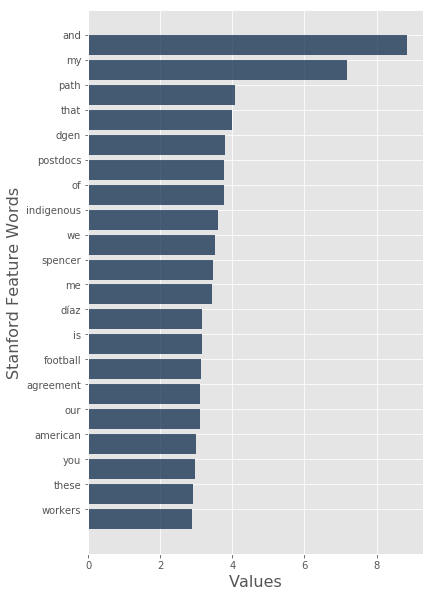

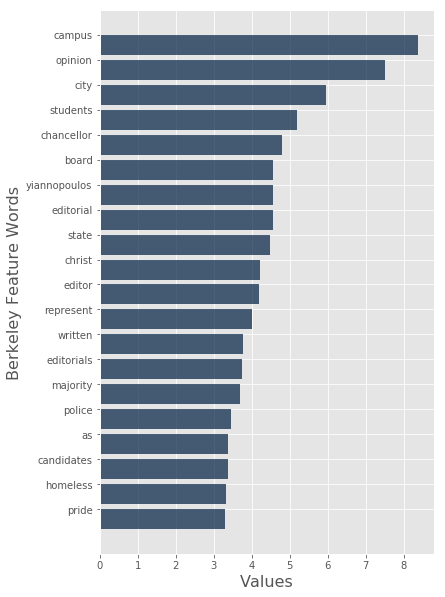

In [44]:
test_classifier_model(content, publication)

### Just out of curiousity... 
We also tried out model just the headlines of the articles (not the content), and we see that the classifier did significantly poorer with just the headline information. Although the key features of the headlines model are quite revealing of content of the articles.  

Classifier model score:  0.709677419355

Top features for Stanford articles:
['order', 'voces', 'secreto', 'is', 'we', 'removed', 'incapacity', 'or', 'impeached', 'reform', 'countering', 'hateful', 'why', 'stolen', 'and', 'storytelling', 'board', 'editorial', 'letter', 'the']

Top features for Berkeley articles:
['must', 'christ', 'carol', 'campus', 'not', 'referendum', 'vote', 'for', 'no', 'state', 'vice', 'as', 'students', 'yes', 'student', 'policy', 'free', 'protests', 'vigilant', 'guardians']

There are  107  nuetral words. Here are the first 25: 
['general', 'dark', 'michael', 'understanding', 'role', 'form', 'tendencies', 'root', 'gould', 'tapping', 'tap', 'takes', 'business', 'venezuela', 'russia', 'most', 'mourning', 'ben', 'behalf', 'involves', 'real', 'small', 'intolerance', 'neglected', 'staff']



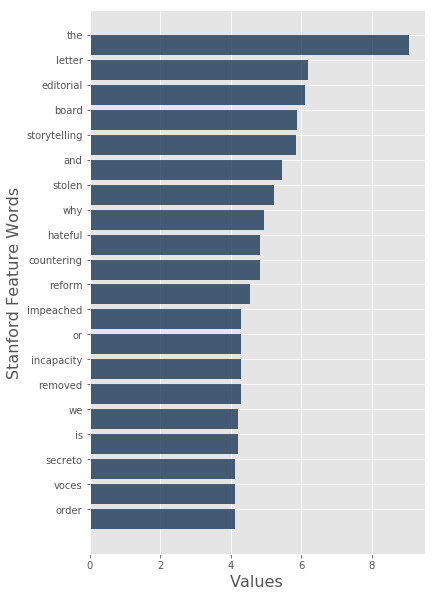

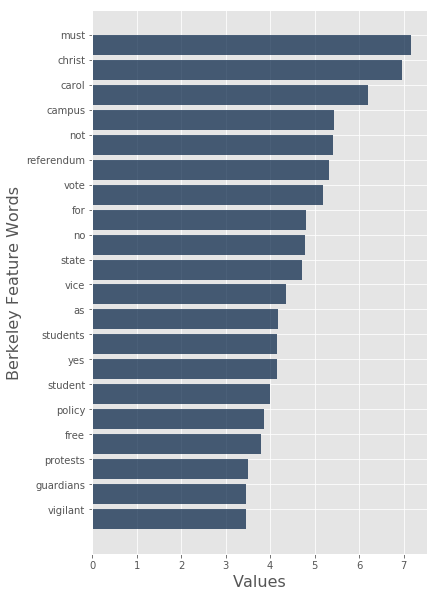

In [45]:
headlines = info_table.column('Headline')
headlines = replace_word(headlines, 'berkeley', 'college')
headlines = replace_word(headlines, 'stanford', 'college')
headlines = replace_word(headlines, 'uc', '') #also replacing 'UC' which is associated with 'UC' Berkeley
headlines = replace_word(headlines, 'cal', 'college')
test_classifier_model(headlines, publication)

# Classification Results 
Even by replacing 'berkeley', 'stanford', 'cal', and 'uc', our model scores very high (about 90 percent)! Even just looking at the headlines gave us a fairly high rate (about 71 percent). 

This gives us reason to believe that the content Daily Cal covers v. the content Stanford Daily covers is quite different. 

### Some points of interest 
Just by glancing at some of the differences in top features words, we get a little bit of an idea of how the two publication's content differs. 
1. Some of the key words are perhaps telling of culture: Berkeley articles' feature words include "police", "homeless", "pride". Stanford articles' feature words include "workers", "american", "football".
2. Other keywords refer to speakers. For Berkeley, there was a lot of buzz around Milo Yiannopoulos coming. Whereas for Stanford, there was a lot of conversation on Robert Spencer coming.
3. Some of the keywords seem like obviously specific differences. For example, Berkeley has "christ" as a top feature word, referring to our new chancellor. Stanford has "dgen" as a top feature word, referring to Stanford's Diversity and First-Generation program.   

In the next steps, we will further explore how the content is different. 

# Testing Bias

We had a lot of ideas paired with potential problems for testing bias. While we discussed testing political leaning through Word embedding and the Dictionary Method, we decided that the most straightforward way to go about it is through Classification. The Washington Post published a graph showing audience views on publication conservative or liberal leanings.  

![title](image/publication-leanings)

From here, we can see publications like The New Yorker and CNN are considered liberal versus publications like The Blaze and Fox News are considered conservative. We decided articles from these publications would make a good basis for a classifier model. We collected articles from the front page of 8 different publications, 4 that are left of the 0 and considered more consistently liberal (NPR, The Slate, The New Yorker, and CNN) and 4 that are to the right of 0 and considered more consistently conservate (Breitbart, Fox News, The Blaze, and Sean Hannity Show). These articles can provide a classifier model with data on articles that are associated with liberal v conservative publications. 

In [46]:
with open("data/npr_corpus.txt") as f:
    npr = f.read()
    
with open("data/slate_corpus.txt") as f:
    slate = f.read()

with open("data/new_yorker_corpus.txt") as f:
    newyorker = f.read()
    
with open("data/cnn_corpus.txt") as f:
    cnn = f.read()
    
with open("data/breitbart_corpus.txt") as f:
    breitbart = f.read()
    
with open("data/fox_news_corpus.txt") as f:
    fox = f.read()
    
with open("data/blaze_corpus.txt") as f:
    blaze = f.read()
    
with open("data/sean_hannity_corpus.txt") as f:
    hannity = f.read()

In [47]:
def create_info(text, publication):
    article_lst = text.split("\n\n\n\n")
    i = 1
    all_info = []
    for article in article_lst:
        article = article.strip().split("\n")
        url  = "Error"
        headline = "Error"
        content = ""
        bias = ''
        placement = 0
        if publication == "NPR" or publication == "The New Yorker" or publication == "Slate" or publication == "CNN":
            bias = 'liberal'
            if publication == "NPR":
                placement =  -4.8
            elif publication == "CNN":
                placement = -2
            else:
                placement = -5.9
        else: 
            bias = 'conservative'
            if publication == "Fox News":
                placement = 2
            else:
                placement = 5.9
        for index in range(len(article)):
            if index == 0:
                url = article[index]
            elif index == 1:
                headline = article[index]
            else:
                content = content + article[index]
        information = [publication, url, headline, content, bias, placement]
        all_info.append(information)
    return all_info

def create_publication_table(all_info):
    publication = make_array()
    links = make_array()
    headlines = make_array()
    content = make_array()
    bias = make_array()
    placement = make_array()
    for article in all_info:
        publication = np.append(publication, article[0])
        links = np.append(links, article[1])
        headlines = np.append(headlines, article[2])
        content = np.append(content, article[3])
        bias = np.append(bias, article[4])
        placement = np.append(placement, article[5])
    return Table().with_columns('Publication', publication,
                               'Link', links, 'Headline', headlines, 
                                'Content', content, 'Bias', bias,
                               'Placement', placement)

publication_info = (create_info(npr, "NPR") + create_info(slate, "Slate") 
                    + create_info(newyorker, "The New Yorker") + create_info(cnn, "CNN")
                    + create_info(breitbart, "Breitbart") + create_info(fox, "Fox News")
                    + create_info(blaze, "The Blaze") + create_info(hannity, "Sean Hannity Show"))
# NPR: 27, Slate: 15, The New Yorker: 8, CNN: 24, Breitbart: 20, Fox News: 20, The Blaze: 13, Sean Hannity Show: 15
publication_table = create_publication_table(publication_info)
publication_table

Publication,Link,Headline,Content,Bias,Placement
NPR,https://www.npr.org/2017/12/02/567882076/fact-check-how- ...,FACT CHECK: How Does Paul Ryan's Case For Tax Cuts Match ...,"House Speaker Paul Ryan, R-Wis., is moving close to vict ...",liberal,-4.8
NPR,https://www.npr.org/2017/12/01/567446997/tax-bill-would- ...,Tax Bill Would Give Small Brewers A Big Break,Craft breweries might be about to crack open a celebrato ...,liberal,-4.8
NPR,https://www.npr.org/2017/11/02/561639579/chart-how-the-t ...,CHART: How The Republican Tax Overhaul Would Affect You,"Late on Tuesday, Senate Republicans released an updated ...",liberal,-4.8
NPR,https://www.npr.org/2017/12/01/567758536/mcconnell-says- ...,Senate Republicans Pass Massive Tax Overhaul,The Senate narrowly approved a $1.4 trillion tax overhau ...,liberal,-4.8
NPR,https://www.npr.org/sections/thetwo-way/2017/12/03/56818 ...,CVS To Buy Health Insurer Aetna For $69 Billion,CVS is preparing to buy the health insurance giant Aetna ...,liberal,-4.8
NPR,https://www.npr.org/2017/12/03/568133048/women-of-color- ...,When Black Women's Stories Of Sexual Abuse Are Excluded ...,The recent cultural reckoning over sexual assault and ha ...,liberal,-4.8
NPR,https://www.npr.org/sections/thetwo-way/2017/12/04/56824 ...,Grassley: Ending Estate Tax Recognizes Investors Over Sp ...,"Iowa Republican Sen. Chuck Grassley, commenting on the G ...",liberal,-4.8
NPR,https://www.npr.org/2017/12/03/567282814/new-jersey-take ...,New Jersey Takes On Major Professional Sports Leagues In ...,The justices of the U.S. Supreme Court have been known t ...,liberal,-4.8
NPR,https://www.npr.org/2017/12/03/567602293/what-living-on- ...,"What Living On $100,000 A Year Looks Like",A central question of debate leading up to the Senate's ...,liberal,-4.8
NPR,https://www.npr.org/sections/ed/2017/12/03/564825033/how ...,"How To Motivate 80,000 Teachers","""I was talking to a secondary teacher in Uganda,"" Sharat ...",liberal,-4.8


Now that we have the data from various publications in one table, we can start building a classifier. Our idea was to build two classifiers. The first will classify articles in binary categories: liberal or conservative. The second will classify articles on a scale from -10 to 10. We will start by predicting whether an article is liberal or conservative
### Prediction bias 
We want to predict the bias, given the content of the article. It is either liberal or conservative. Using the rankings from the Washington Post graph, anything left of the 0 is considered liberal and anything right of the 0 is considered conservative. This binary classification would be better suited for a logistical regression. We can calculate the ratio of liberal to conservative classified Daily Cal articles to the ratio of liberal to conservative classified Stanford Daily articles. From there, we can see how the two compare.

Before we classify Stanford Daily and Daily Cal articles as liberal or conservative, we wanted to see how good our classifier is and what some key feature words are to distinguish between liberal and conservative. As you can see, we decided to remove stop words like ('and', 'the', and 'to') in the classifier model. We also removed the names of publications such as 'fox' and 'cnn' from swaying the results.

Classifier model score:  0.704225352113

Top features for Liberal articles:
['39', 'neyfakh', 'daca', 'teachers', 'indicate', 'know', 'cvs', 'vanguard', 'women', 'sports', 'monument', 'land', 'vote', 'flynn', 'church', 'census', 'court', 'spacey', 'new', 'says']

Top features for Conservative articles:
['president', 'news', 'obama', 'moore', 'film', 'rate', 'increase', 'owner', 'gun', 'officers', 'abc', 'ross', 'manning', 'hillary', 'molestation', 'added', 'handler', 'reid', 'tweeted', 'statement']

There are  4129  nuetral words. Here are the first 25: 
['jerseys', 'fist', 'fishing', 'fishermen', 'firsthand', 'firmly', 'rosebut', 'firewood', 'firearms', 'firearm', 'finland', 'finished', 'rosewomen', 'fingers', 'roster', 'fines', 'fit', 'fitness', 'fitting', 'fiving', 'flexibility', 'fleshbot', 'rooms', 'fled', 'flawed']



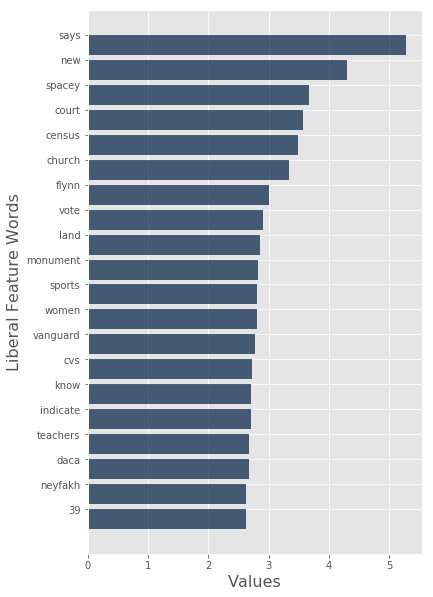

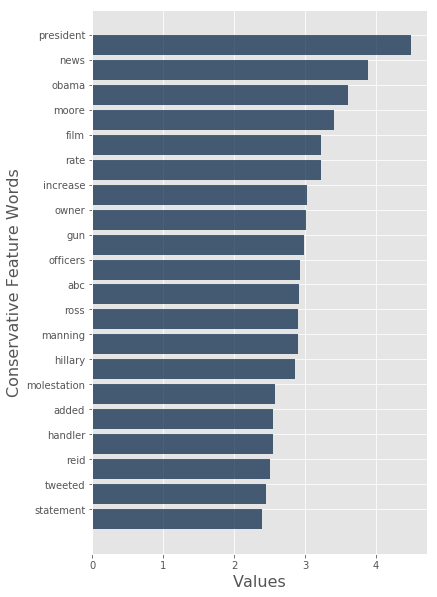

In [48]:
def test_log_classifier_model(con, bias): 
    np.random.seed(1)
    x, y = shuffle(con, bias, random_state=0)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=50)

    # get tfidf values
    tfidf = TfidfVectorizer(stop_words = 'english')
    tfidf.fit(x)
    x_train = tfidf.transform(x_train)
    x_test = tfidf.transform(x_test)

    # build and test logit
    logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
    model = logit_class.fit(x_train, y_train)
    feature_names = tfidf.get_feature_names()
    
    print("Classifier model score: ", model.score(x_test, y_test))
    print()
    
    print("Top features for Liberal articles:")
    top20liberal = np.argsort(model.coef_[0])[-20:]
    top_liberal_feats = list(feature_names[j] for j in top20liberal)
    top_liberal_values = list(model.coef_[0][j] for j in top20liberal) 
    print(top_liberal_feats)
    top_liberal = Table().with_columns('Liberal Feature Words', top_liberal_feats, 'Values', top_liberal_values).sort('Values', descending = True)
    top_liberal.barh('Liberal Feature Words', 'Values')
    
    print()
    
    print("Top features for Conservative articles:")
    top20conservative = np.argsort(model.coef_[0])[:20] # list of indices (respective of feature_names) with top feature words for Daily Cal
    top_conservative_feats = list(feature_names[j] for j in top20conservative)
    top_conservative_values = list(model.coef_[0][j] for j in top20conservative) 
    print(top_conservative_feats)   
    scaling = np.sum(np.abs(model.coef_[0]))
    top_conservative = Table().with_columns('Conservative Feature Words', top_conservative_feats, 'Values', np.abs(top_conservative_values)).sort('Values', descending = True)
    top_conservative.barh('Conservative Feature Words')
    print()
    
    #nuetral_words = (np.argsort(np.abs(model.coef_[0])))[:20]
    nuetral_words_indices = (np.argsort(np.abs(model.coef_[0])))
    nuetral_words_values = np.sort((np.abs(model.coef_[0])))
    val = 0
    index = 0
    nuetral_words = []
    while val == 0:
        nuetral_words.append(feature_names[nuetral_words_indices[index]])
        index += 1
        val = nuetral_words_values[index]
    print("There are ", len(nuetral_words), " nuetral words. Here are the first 25: " )
    print(nuetral_words[:25])
    print()
    return 

content = publication_table.column('Content')
content = replace_word(content, 'fox', '')
content = replace_word(content, 'hannity', '')
content = replace_word(content, 'yorker', '')
content = replace_word(content, 'cnn', '')
content = replace_word(content, 'breitbart', '')
content = replace_word(content, 'slate', '')
content = replace_word(content, 'blaze', '')
content = replace_word(content, 'npr', '')

test_log_classifier_model(content, publication_table.column('Bias'))

Wow! The model is not bad. The feature words also seem fairly insightful. While liberal publications feature words include 'church', 'vote', 'women', 'teachers', and 'daca', conservative publications feature words include 'obama', 'gun', 'officers', and 'hilary'. 

Now that we see this method of classification outputs fairly reasonable conclusions, let's try building a model to test our data from The Daily Cal and The Stanford Daily. 

In [49]:
def build_log_classifier_model(train_con, train_bias, test_con, info_table): 
    
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=50)
    x_train, x_test, y_train = train_con, test_con, train_bias
    x = np.append(x_train, x_test)

    # get tfidf values
    tfidf = TfidfVectorizer(stop_words = 'english')
    tfidf.fit(x)
    x_train = tfidf.transform(x_train)
    x_test = tfidf.transform(x_test)

    # build and test logit
    logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
    model = logit_class.fit(x_train, y_train)
    
    predictions = model.predict(x_test)
    return info_table.with_column('Predicted Bias', predictions)

In [50]:
content = publication_table.column('Content')
content = replace_word(content, 'fox', '')
content = replace_word(content, 'hannity', '')
content = replace_word(content, 'yorker', '')
content = replace_word(content, 'cnn', '')
content = replace_word(content, 'breitbart', '')
content = replace_word(content, 'slate', '')
content = replace_word(content, 'blaze', '')
content = replace_word(content, 'npr', '')

biases = publication_table.column('Bias')

testing_content = info_table.column('Content')
testing_content = replace_word(testing_content, 'berkeley', 'college')
testing_content = replace_word(testing_content, 'stanford', 'college')
testing_content = replace_word(testing_content, 'uc', '') #also replacing 'UC' which is associated with 'UC' Berkeley
testing_content = replace_word(testing_content, 'cal', 'college')

In [51]:
bias_table = build_log_classifier_model(content, biases, testing_content, info_table)
bias_table

Publication,Link,Date,Headline,Content,Predicted Bias
Daily Cal,www.dailycal.org/2017/11/14/alta-bates-planned-closure-p ...,['11' '14' '2017'],Alta Bates planned closure puts Berkeley residents at risk,CITY AFFAIRS: Community members have mobilized recently ...,liberal
Daily Cal,www.dailycal.org/2017/11/07/berkeley-community-fight-stay/,['11' '07' '2017'],"Berkeley community here to fight, here to stay",NATIONAL ISSUES: A look at Berkeley one year after the N ...,liberal
Daily Cal,www.dailycal.org/2017/11/03/berkeley-mayor-must-explicit ...,['11' '03' '2017'],Berkeley mayor must explicitly call out racial disparity ...,CITY AFFAIRS: City Council punted on two major Berkeley ...,conservative
Daily Cal,www.dailycal.org/2017/10/31/event-policy-draft-use-impro ...,['10' '31' '2017'],Event policy draft could use improvement,CAMPUS ISSUES: Student organizations may suffer the cons ...,conservative
Daily Cal,www.dailycal.org/2017/10/27/history-visual-propaganda-no ...,['10' '27' '2017'],"History of visual propaganda, stereotypes should not be ...",CAMPUS ISSUES: A recent editorial cartoon stoked valid c ...,liberal
Daily Cal,www.dailycal.org/2017/10/24/current-climate-new-vice-cha ...,['10' '24' '2017'],"In current climate, new vice chancellor of equity and in ...","CAMPUS ISSUES: Oscar Dubón, Jr. will need a clearer visi ...",liberal
Daily Cal,www.dailycal.org/2017/10/20/new-law-aiming-restrict-uc-c ...,['10' '20' '2017'],New law aiming to restrict UC campuses from giving enrol ...,UNIVERSITY ISSUES: California lawmakers should not waste ...,conservative
Daily Cal,www.dailycal.org/2017/10/17/berkeley-far-ready-next-big- ...,['10' '17' '2017'],Berkeley far from ready for next big hills fire,CITY AFFAIRS: As California grapples with wildfire month ...,liberal
Daily Cal,www.dailycal.org/2017/10/13/asuc-cannot-neglect-sexual-v ...,['10' '13' '2017'],ASUC cannot neglect sexual violence prevention commission,CAMPUS ISSUES: The ASUC Senate is supposed to approve th ...,liberal
Daily Cal,www.dailycal.org/2017/10/10/new-university-wisconsin-pol ...,['10' '10' '2017'],New University of Wisconsin policy hypocritically exploi ...,"NATIONAL ISSUES: The new policy comes amid a perceived "" ...",conservative


Great, we have a table that has the content of Daily Cal and Stanford Daily articles along with the predicted classified. Now let's compare the ratio of liberal to conservative articles for the Daily Cal with the ratio of liberal to conservative articles for the Stanford Daily.

In [52]:
calbias = bias_table.where('Publication', 'Daily Cal').column('Predicted Bias')
print('From our data, we classified', np.count_nonzero(calbias == 'liberal'), 'Daily Californian articles as liberal and', np.count_nonzero(calbias == 'conservative'), 'articles as conservative')
print('The ratio of liberal to conservative articles for the Daily Cal:',  np.count_nonzero(calbias == 'liberal')/ np.count_nonzero(calbias == 'conservative'))
print()
stanfordbias = bias_table.where('Publication', 'Stanford Daily').column('Predicted Bias')
print('From our data, we classified', np.count_nonzero(stanfordbias == 'liberal'), 'Stanford Daily articles as liberal and', np.count_nonzero(stanfordbias == 'conservative'), 'articles as conservative')
print('The ratio of liberal to conservative articles for the Stanford Daily:',  np.count_nonzero(stanfordbias == 'liberal')/ np.count_nonzero(stanfordbias == 'conservative'))

From our data, we classified 42 Daily Californian articles as liberal and 39 articles as conservative
The ratio of liberal to conservative articles for the Daily Cal: 1.0769230769230769

From our data, we classified 44 Stanford Daily articles as liberal and 27 articles as conservative
The ratio of liberal to conservative articles for the Stanford Daily: 1.6296296296296295


## Confidence Interval

Our classification model seems to show that The Daily Cal is more conservative than the Stanford Daily, although both have more liberal articles. However judging from our small margin of difference between liberal and conservative articles, we questioned whether the difference is due to chance. To test this, we decided to simulate this, by randomly assigning 'liberal' or 'conservative' 100 times and taking the ratio of liberal to conservative. We will simulate this 10,000 times to create a confidence interval 

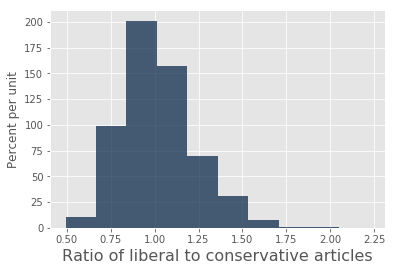

In [53]:
repetitions = 10000
bias = make_array('liberal', 'conservative')
test_stats = make_array()
for _ in range(repetitions):
    sample = np.random.choice(bias, 100)
    test_stat = np.count_nonzero(sample == 'liberal')/np.count_nonzero(sample == 'conservative')
    test_stats = np.append(test_stats, test_stat)

simulated_ratio = Table().with_column('Ratio of liberal to conservative articles', test_stats)
simulated_ratio.hist()

In [54]:
lower_end = percentile(2.5, test_stats)
upper_end = percentile(97.5, test_stats)
print('Confidence interval of', lower_end, 'to', upper_end)

Confidence interval of 0.666666666667 to 1.5


From our confidence interval, we are unable to say the Daily Cal produces more liberal articles than conservative. However, we can say, with a 95 percent ocnfidence interval, that it seems that the Stanford Daily produces more liberal articles than conservative. As 1.6296 (Stanford Daily liberal to conservative article ratio) does not lie within our confidence interval, this gives us reason to believe that the difference in liberal to conservative articles published by the Stanford Daily is due to more than just chance. On the other hand, 1.0769 (Daily Cal liberal to conservative article ratio) does fall within the confidence interval, and therefore, we can not conclude that the Daily Cal seems to publish more liberal articles that conservative.

Now, let's check our findings using a logistic regression model with a linear regression model that utilizes how bias the publication was considered by the audience (according to the Washington Post)

### Bias placement
In our table, we also kept track of how far right or left the publication bias was considered. We are hoping to be able to quantify how bias Stanford Daily and Daily cal is on a -10 to 10 scale based on inputs from these publication. We want to predict how bias an article is, given the content of the article. This scale based classification would be better suited for a linear regression classifier. 

In [55]:
def linear_model_classifier(train_con, train_bias, test_con, info_table):
    
    x_train, x_test, y_train = train_con, test_con, train_bias
    x = np.append(x_train, x_test)

    # get tfidf values
    tfidf = TfidfVectorizer(stop_words = 'english')
    tfidf.fit(x)
    x_train = tfidf.transform(x_train)
    x_test = tfidf.transform(x_test)
    
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    predictions = linreg.predict(x_test)
    return info_table.with_column('Predicted bias placement', predictions)
    

placement_table = linear_model_classifier(content, publication_table.column('Placement'), testing_content, info_table)
placement_table

Publication,Link,Date,Headline,Content,Predicted bias placement
Daily Cal,www.dailycal.org/2017/11/14/alta-bates-planned-closure-p ...,['11' '14' '2017'],Alta Bates planned closure puts Berkeley residents at risk,CITY AFFAIRS: Community members have mobilized recently ...,-0.804791
Daily Cal,www.dailycal.org/2017/11/07/berkeley-community-fight-stay/,['11' '07' '2017'],"Berkeley community here to fight, here to stay",NATIONAL ISSUES: A look at Berkeley one year after the N ...,-0.734792
Daily Cal,www.dailycal.org/2017/11/03/berkeley-mayor-must-explicit ...,['11' '03' '2017'],Berkeley mayor must explicitly call out racial disparity ...,CITY AFFAIRS: City Council punted on two major Berkeley ...,0.558336
Daily Cal,www.dailycal.org/2017/10/31/event-policy-draft-use-impro ...,['10' '31' '2017'],Event policy draft could use improvement,CAMPUS ISSUES: Student organizations may suffer the cons ...,0.108257
Daily Cal,www.dailycal.org/2017/10/27/history-visual-propaganda-no ...,['10' '27' '2017'],"History of visual propaganda, stereotypes should not be ...",CAMPUS ISSUES: A recent editorial cartoon stoked valid c ...,-0.852709
Daily Cal,www.dailycal.org/2017/10/24/current-climate-new-vice-cha ...,['10' '24' '2017'],"In current climate, new vice chancellor of equity and in ...","CAMPUS ISSUES: Oscar Dubón, Jr. will need a clearer visi ...",-0.941344
Daily Cal,www.dailycal.org/2017/10/20/new-law-aiming-restrict-uc-c ...,['10' '20' '2017'],New law aiming to restrict UC campuses from giving enrol ...,UNIVERSITY ISSUES: California lawmakers should not waste ...,0.275765
Daily Cal,www.dailycal.org/2017/10/17/berkeley-far-ready-next-big- ...,['10' '17' '2017'],Berkeley far from ready for next big hills fire,CITY AFFAIRS: As California grapples with wildfire month ...,-1.00556
Daily Cal,www.dailycal.org/2017/10/13/asuc-cannot-neglect-sexual-v ...,['10' '13' '2017'],ASUC cannot neglect sexual violence prevention commission,CAMPUS ISSUES: The ASUC Senate is supposed to approve th ...,-1.49313
Daily Cal,www.dailycal.org/2017/10/10/new-university-wisconsin-pol ...,['10' '10' '2017'],New University of Wisconsin policy hypocritically exploi ...,"NATIONAL ISSUES: The new policy comes amid a perceived "" ...",-0.141954


Our classifier has predicted a bias associated with each article. Let's visualize the results for each publication. 

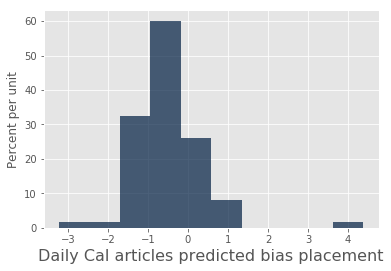

In [56]:
placement_table.where('Publication', 'Daily Cal').relabel(5, 'Daily Cal articles predicted bias placement').hist(5)

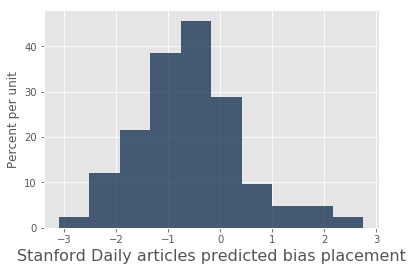

In [57]:
placement_table.where('Publication', 'Stanford Daily').relabel(5, 'Stanford Daily articles predicted bias placement').hist(5)

In [58]:
print('If we say that the bias of a publication is the mean bias of the articles published by that publication, then we can conclude the following.')
print()

cal_placements = placement_table.where('Publication', 'Daily Cal').column(5)
print("Daily Cal's publication bias:", np.mean(cal_placements))

stanford_placements = placement_table.where('Publication', 'Stanford Daily').column(5)
print("Stanford Daily's publication bias:", np.mean(stanford_placements))

If we say that the bias of a publication is the mean bias of the articles published by that publication, then we can conclude the following.

Daily Cal's publication bias: -0.499592753659
Stanford Daily's publication bias: -0.610467709495


Both publications are classified left leaning. However, the classifier indicates Stanford Daily has a stronger bias than the Daily Cal. This aligns with our findings using the logistic regression model as well. 

# Looking Forward

In the future, I would like alter our corpus for better results. For one, our corpus size does not feel large enough to warrant accuracy. My second concern has to do with our goal of uncovering “hidden bias”. Our corpus for collegiate publications only examines opinion articles. While these  articles are likely to have biases, they are not particularly “hidden”. I would like to examine how bias filters through news stories. What stories to liberal publications chose to tell and not tell versus conservative publications? Are the same events reported on differently by liberal and conservative publications? 
	
I believe the ‘distant reading’ approach is crucial component of understanding bias. The problem with examining bias through ‘close reading’ is the definition of bias varies depending on the reading. There are no particular guidelines or a definitive definition for bias. Therefore, the best way to quantify it is with respect to a broad range of texts. While our method certainly has its flaws, a computational approach that compares texts provides a necessary broader context for understanding bias.

### Creating bias classifier that takes in account both content and sentiment

Upon further inspect, however, I started to doubt the accuracy of the classifier. For example, a Daily Cal editorial about how “kneeling during the [national] anthem would send a powerful message to these viewers that college athletes do not turn a blind eye to systemic racism” was classified with a 4.38047 conservative bias. The jarring problem with this method of detecting bias is it does not take sentiment. For example, an article that talks a lot about Hillary in a positive light differs in bias from an article that talks about her in a negative light. Creating a classifier that takes in account both the content of the article and the sentiment, I think, would produce better results. This classifier would not only take in account what publications decide to cover, but also how it is covered.


### Potential next steps

#### Examining political leaning through Word embedding 

1. Daily Cal often accused of being a left-leaning organization. Can we examine this statement? How does its leaning compare with Stanford Daily?

2. Similar to he/she gender binary we had looked at in class, we would have our two polar ends be conservative v. liberal

3. Problem: How do we differentiate in words between conservative and liberal through keywords? (In our gender analysis, we used "he" and "she")

#### Examining political leaning through Dictionary Method 

1. Do Daily Cal language and dialogue align more with left than right? 

2. Problem: Does a bias-checker dictionary exist? Is it accurate/fair? 

#### Textual Clustering  within publication 

1. How does one piece of Daily Cal content compare with the rest?  

2. Are there any outliers? Is there a clear pattern? What would this pattern tell us? 

#### Time analysis using Textual Clustering 

1. Start by representing every article as a vector. Using multidimensionality reduction, we can visually see how the content differs from each other. Is proximity of articles related to the time it was published (gathered metadata)?
